Proces ucitavanja grafova je isti kao u kodu za geneticki algoritam za resavanje problema Minimalnog Stainerovog stabla.

In [1]:
def loadGraphFromFile(file_name):

        n_nodes = 0
        n_edges = 0
        n_terminals = 0

        edges = []
        terminals = []

        with open(file_name, 'r') as file:

            for line in file:
                word_list = line.split()

                if(len(word_list) == 0):
                    continue

                if(word_list[0] == 'Nodes'):
                    n_nodes = int(word_list[1])

                if(word_list[0] == 'Edges'):
                    n_edges = int(word_list[1])

                if(word_list[0] == 'Terminals'):
                    n_terminals = int(word_list[1])

                if(word_list[0] == 'E'):
                    edges.append([int(word_list[1]) - 1, int(word_list[2]) - 1, int(word_list[3])])

                if(word_list[0] == 'T'):
                    terminals.append(int(word_list[1]) - 1)
                    
        return [n_nodes, n_edges, n_terminals, edges, terminals]

In [2]:
class SteinerTree:
    
    def __init__(self, file_name, opt):
        
        initList = loadGraphFromFile(file_name)
        
        self.name = file_name[-7:-4]
        self.opt = opt
        self.numNodes = initList[0]
        self.numEdges = initList[1]
        self.numTerms = initList[2]
        self.edges = initList[3]
        self.terminals = initList[4]

In [3]:
bGraphList = [
    ('b01.stp', 82),
    ('b02.stp', 83),
    ('b03.stp', 138),
    ('b04.stp', 59),
    ('b05.stp', 61),
    ('b06.stp', 122),
    ('b07.stp', 111),
    ('b08.stp', 104),
    ('b09.stp', 220),
    ('b10.stp', 86),
    ('b11.stp', 88),
    ('b12.stp', 174),
    ('b13.stp', 165),
    ('b14.stp', 235),
    ('b15.stp', 318),
    ('b16.stp', 127),
    ('b17.stp', 131),
    ('b18.stp', 218)
]

In [4]:
import os

bDataPath = os.path.abspath(os.getcwd()) + '\\..\\data\\B'

print(bDataPath)
filenames = os.listdir(bDataPath)
print(filenames)

bGraphs = []

for st_args in bGraphList:
    graphpath = bDataPath + '\\' + st_args[0]
    graphopt = st_args[1]
    bGraphs.append(SteinerTree(graphpath, graphopt))
    
print(len(bGraphs))
print(bGraphs[9].name)

G:\RI\Projekat\RI-Min-Steiner-Tree\code\..\data\B
['b01.stp', 'b02.stp', 'b03.stp', 'b04.stp', 'b05.stp', 'b06.stp', 'b07.stp', 'b08.stp', 'b09.stp', 'b10.stp', 'b11.stp', 'b12.stp', 'b13.stp', 'b14.stp', 'b15.stp', 'b16.stp', 'b17.stp', 'b18.stp']
18
b10


In [5]:
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse.csgraph import connected_components

#### Diskretna optimizacija rojem cestica za resavanje problema Stainerovog stabla

Sledeci algoritam je inspirisan radom Binary particle swarm optimization (BPSO) based state assignment for area minimization of sequential circuits (https://www.sciencedirect.com/science/article/pii/S1568494613002688#eq0030).

Cestica kodira jedno resenje problema. Predstavlja niz istinitosnih vrednosti koje oznacavaju da li je ne-terminalni cvor ukljucen u formiranje Steinerovog stabla.

Generisanje populacije cestica vrsi se slucajno sa duplo vecom verovatnocom da proizvoljni cvor bude izabran. Ovo je uradjeno zbog toga da pocetna populacija ima vece sanse da proizvede povezano stablo.

Pocetna brzina cestice je niz float vrednosti koja je proporcijalna verovatnoci da ce gen cestice promeniti vrednost.

Azuriranje brzine vrsi se po formuli:

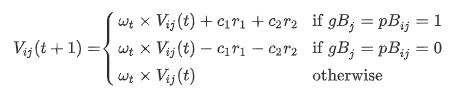

gde su c1 i c2 konstante, r1 i r2 slucajne vrednosti iz opsega (0, 1), a wt faktor inercije dobijen
formulom:

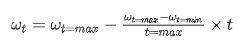

Azuriranje pozicije vrsi se po formuli:

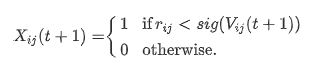

Evaluacija cestice se radi na isti nacin kao kod Genetskog algoritma, pomocu Minimalnog razapinjuceg stabla.

In [23]:
import numpy as np

#generise se jedno resenje
def generateSolution(solution_len):
    
    sol = []

    for j in range(solution_len):

        sol.append(round(np.random.uniform(0.25, 1)))

    return sol

#evaluira se svaki resenje, racunanjem vrednosti minimalnog razapinjuceg stabla
def evaluateSolution(p, solution_len, terminal_list, adj_matrix):
    
    total_value = np.sum(adj_matrix) / 2
    
    N = len(adj_matrix)
        
    s = 0

    selected_nodes = np.copy(terminal_list)

    for t in range(len(terminal_list)):

        if(selected_nodes[t] == 1):
            t = t+1
        else:
            selected_nodes[t] = p[s]
            s = s+1

    #pravi se nova matrica susedstva za izabrane cvorove
    M = sum(selected_nodes)

    new_adj_matrix = np.zeros((int(M), int(M)))

    m = 0

    for i in range(N):

        if(selected_nodes[i] == 1):

            n = 0

            for j in range(N):

                if(selected_nodes[j] == 1):

                    new_adj_matrix[m][n] = adj_matrix[i][j]

                    n = n+1
            m = m+1


    X = csr_matrix(new_adj_matrix.tolist())

    #provera da li je dobijen graf povezan
    #mora biti povezan da bi se racunao za Stainerovo drvo
    n_components, labels = connected_components(csgraph=X, directed=False, return_labels=True)
    
    if(n_components != 1):
        return (total_value, 0)
    
    #vraca gornje-trougaonu matricu povezanosti minimalnog razapinjuceg stabla
    Tcsr = minimum_spanning_tree(X)
    value = sum(sum(Tcsr.toarray().astype(int)))

    return (value, 1)

def makeFeasible(sol, solution_len, terminal_list, adj_matrix):
    
    new_sol = sol.copy()
    
    is_feasible = 0
    
    while not is_feasible:
        num_of_zeros = solution_len - np.count_nonzero(sol)
        
        index_of_change = np.random.randint(num_of_zeros)
        
        i = 0
        
        z_count = 0
        
        while i < solution_len:
            
            if(sol[i] == 0):
                z_count = z_count + 1
                
                if(z_count == index_of_change + 1):
                    new_sol[i] = 1
            
            i = i+1
            
        [val, is_feasible] = evaluateSolution(new_sol, solution_len, terminal_list, adj_matrix)
        
    return (new_sol, val, is_feasible)
        

def DPSO(st: SteinerTree):
    
    N = st.numNodes
    edge_number = st.numEdges
    term_number = st.numTerms
    optimal = st.opt
    edges = st.edges
    terminals = st.terminals
    
    terminal_list = np.zeros(N)
    
    for t in terminals:
        terminal_list[t] = 1
    
    #zaustavlja se iteriranje ako dobijemo optimalno resenje
    success = 0
    
    adj_matrix = np.zeros((N, N))
    
    for e in edges:
        adj_matrix[e[0]][e[1]] = e[2]
        adj_matrix[e[1]][e[0]] = e[2]
    
    total_value = np.sum(adj_matrix) / 2
    
    
    #maksimalan broj iteracija
    MAX_ITER = 5000
    
    #ogranicenja brzine
    V_MAX = 4
    V_MIN = -4
    
    #velicina populacije
    population_size = 10
    
    #velicina jedinke
    solution_len = N - term_number
    
    population = []
    personal_best = []
    personal_best_value = []
    pop_velocity = []
    pop_eval = []
    
    i = 0
    
    while(i < population_size):
        
        sol = generateSolution(solution_len)
        val, is_feasable = evaluateSolution(sol, solution_len, terminal_list, adj_matrix)
        
        if(is_feasable):
            population.append(sol)
            personal_best.append(sol)
            pop_eval.append(val)
            personal_best_value.append(val)
            
            #generise se random brzina za novodobijenu cesticu
            vel = []
            
            for j in range(solution_len):
                vel.append(np.random.uniform(V_MIN, V_MAX))
                
            pop_velocity.append(vel)
            
        else:
            #uraditi opet iteraciju
            i = i-1
            
        i = i+1
        
    print(pop_eval)
        
    global_best_value = min(pop_eval)
    global_best_index = pop_eval.index(global_best_value)
    global_best = np.copy(population[global_best_index])
    
    func_eval_GA = 0
    fit_GA = []
    
    #faktor inercije
    wmax = 0.7
    wmin = 0.1
    
    #konstante u formuli azuriranja brzine
    c1 = 1.5
    c2 = 1.5
    
    for iteration in range(MAX_ITER):
        
        wt = wmax - (wmax - wmin) / MAX_ITER * iteration
        
        for i in range(population_size):
            
            sol = population[i].copy()
            vel = np.copy(pop_velocity[i])
            pBest = personal_best[i]
            
            #aziranje brzina svih cestica
            for j in range(solution_len):
                
                r1 = np.random.rand()
                r2 = np.random.rand()
                
                new_vel = 0
                
                if(global_best[j] == pBest[j] and pBest[j] == 1):
                
                    new_vel = wt * vel[j] + c1*r1 + c2*r2
                    
                elif(global_best[j] == pBest[j] and pBest[j] == 0):
                    
                    new_vel = wt * vel[j] - c1*r1 - c2*r2
                    
                else:
                    
                    new_vel = wt * vel[j]
                    
                if(new_vel > V_MAX):
                    pop_velocity[i][j] = V_MAX
                elif(new_vel < -V_MIN):
                    pop_velocity[i][j] = V_MIN
                else:
                    pop_velocity = new_vel
                    
            #azuranje pozicija cestica
            for j in range(solution_len):
                
                if(np.random.rand() < sigmoid(pop_velocity[i][j])):
                    sol[j] = 1
                else:
                    sol[j] = 0
                    
            [val, is_feasible] = evaluateSolution(sol, solution_len, terminal_list, adj_matrix)
            
            if not is_feasible:
                [sol, val, is_feasible] = makeFeasible(sol, solution_len, terminal_list, adj_matrix)
            
            #azuriranje licnog rekorda cestice
            if(val < personal_best_value[i]):
                
                personal_best[i] = sol.copy()
                personal_best_value[i] = val
                
            
            population[i] = sol.copy()
            pop_eval[i] = val
        
        iteration_best_value = min(pop_eval)
        
        if(iteration_best_value < global_best_value):
            global_best_value = min(pop_eval)
            global_best_index = pop_eval.index(global_best_value)
            global_best = np.copy(population[global_best_index])
        
        func_eval_GA = func_eval_GA + 1
        
        if global_best_value > total_value:
            fit_GA.append(total_value)
        else:
            fit_GA.append(global_best_value)
            
        if global_best_value == optimal:
            break
        
        if(iteration % 100 == 0):
            print(global_best_value)
            
    return (func_eval_GA, fit_GA, global_best, global_best_value)

In [24]:
func_eval_GA, fit_GA, best_solution, best_value = DPSO(bGraphs[0])

[195, 221, 205, 228, 211, 213, 195, 195, 179, 197]
179
167
167
167
167
167
167
167
167
158
158
158
158
158
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121
121


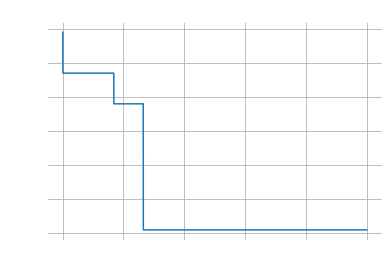

In [25]:
import matplotlib.pyplot as plt

x = np.arange(0, func_eval_GA, 1)
y = fit_GA

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='GA iterations', ylabel='Steiner Tree value',
       title='Genetic algorithm application to b01 dataset')
ax.grid()

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')
ax.title.set_color('white')

plt.show()